In [305]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from Visualization import plot_sampled_frames, animate

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'

In [206]:
class HDir:
    def __init__(self, n, m, tau, l, a, lam, c0, c1=1, print_param=True):
        """
        Parameters
        ----------
        n : int
            Number of neurons along either side of the square sheet of grid cells
        m : int
            Number of preferred directions along either side of a square subregion
        tau : float
            Time constant
        l : float
            Shift amount of the DoG center
        a : float
            Amplitude of the excitatory projection
        lam : float
            Approximate distance between two vertices in the formed pattern
        c0 : float
            Ratio between the inhibitory projection width to excitatory projection width
        c1 : float, optional
            Scale of the weights
        print_param : bool, optional
        """

        if c0 <= 1:
            raise ValueError('Cannot form attractor manifold: c0 <= 1')

        self.N, self.M = n, m
        self.n, self.m = n, m
        self.tau = tau
        self.l = l
        self.a, self.lam, self.c0, self.c1 = a, lam, c0, c1
        self.beta_i = 1/lam**2
        self.beta_e = self.beta_i * c0

        if print_param:
            print('n = %d' % n,
            'm = %d' % m,
            'tau = %.2f' % tau,
            'l = %.2f' % l,
            'a = %.2f' % a,
            'lam = %.2f' % lam,
            'c0 = %.2f' % c0,
            'beta_e = %.2f' % self.beta_e,
            'beta_i = %.2f' % self.beta_i,
            'c1 = %.2f' % c1, sep='\n')

        # preferred directions
        self.theta = np.linspace(-1, 1, num=self.M)
        self.e = np.zeros(n)
        for i in range(n//m):
            np.random.shuffle(self.theta)
            self.e[i*m:(i+1)*m] = self.theta

        # Neuron locations
        self.x = np.linspace(-np.pi, np.pi, num=n, endpoint=False)

        # Calculate distances
        loc = self.x - l * self.e
        dist = np.abs(loc[:, None] - self.x[None, ...])
        dist[dist > np.pi] = 2 * np.pi - dist[dist > np.pi]
        dist = dist**2
        # Weights from DoG
        self.W = c1 * (a * np.exp(-self.beta_e * dist) - np.exp(-self.beta_i * dist))

    def __call__(self, alpha, T, v, landmark=None,
                 s_init=None, spiking=False, print_param=True):
        """
        Parameters
        ----------
        alpha : float
            Velocity input scale
        T : int
            Simulation length
        v : np.ndarray
            Velocity input, with shape (T)
        landmark : np.ndarray, optional
            Landmark neuron input, with shape (T, 1) if given
        s_init : np.ndarray, optional
            Initial neuron state
        spiking : bool, optional
            If the neurons are Poisson spiking neurons
        print_param : bool, optional

        Returns
        -------
        s : np.ndarray
            An array of shape (T, N) storing the neuron states over time
        spike : None or np.ndarray
            An array of shape (T, N) storing the spike train if spiking is enabled
        """

        if print_param:
            print('alpha = %.2f' % alpha,
                  'T = %d' % T, sep='\n')

        s = np.zeros((T, self.N))
        # Init states
        if s_init is None: # Very small perturbations
            s[0] = 0 #np.random.rand(self.N) * 0.01
        else:
            s[0] = s_init.flatten()

        spike = np.zeros((T, self.N)) if spiking else None

        # Calculate external input
        b = np.zeros(self.N)

        for t in range(1, T):
            b = 1 + alpha * self.e * v[t]
            if landmark:
                b += landmark[t]

            p = self.W @ s[t-1] + b # Aux
            p[p < 0] = 0 # ReLU

            if spiking: # numpy array p is the Poisson probability
                rnd = np.random.rand(self.N)

                spike[t] = (rnd <= p).astype(np.int32)

                s[t, rnd <= p] = s[t-1, rnd <= p] + 1

                ds = -s[t-1, rnd > p]
                s[t, rnd > p] = s[t-1, rnd > p] + ds / self.tau

            else: # p is the synaptic input
                ds = -s[t-1] + p
                s[t] = s[t-1] + ds / self.tau

        return s, spike

In [206]:
class HDir2:
    def __init__(self, n, m, tau, l, a, lam, c0, c1=1, print_param=True):
        """
        Parameters
        ----------
        n : int
            Number of neurons along either side of the square sheet of grid cells
        m : int
            Number of preferred directions along either side of a square subregion
        tau : float
            Time constant
        l : float
            Shift amount of the DoG center
        a : float
            Amplitude of the excitatory projection
        lam : float
            Approximate distance between two vertices in the formed pattern
        c0 : float
            Ratio between the inhibitory projection width to excitatory projection width
        c1 : float, optional
            Scale of the weights
        print_param : bool, optional
        """

        if c0 <= 1:
            raise ValueError('Cannot form attractor manifold: c0 <= 1')

        self.N, self.M = n, m
        self.n, self.m = n, m
        self.tau = tau
        self.l = l
        self.a, self.lam, self.c0, self.c1 = a, lam, c0, c1
        self.beta_i = 1/lam**2
        self.beta_e = self.beta_i * c0

        if print_param:
            print('n = %d' % n,
            'm = %d' % m,
            'tau = %.2f' % tau,
            'l = %.2f' % l,
            'a = %.2f' % a,
            'lam = %.2f' % lam,
            'c0 = %.2f' % c0,
            'beta_e = %.2f' % self.beta_e,
            'beta_i = %.2f' % self.beta_i,
            'c1 = %.2f' % c1, sep='\n')

        # preferred directions
        self.theta = np.linspace(-1, 1, num=self.M)
        self.e = np.zeros(n)
        for i in range(n//m):
            np.random.shuffle(self.theta)
            self.e[i*m:(i+1)*m] = self.theta

        # Neuron locations
        self.x = np.linspace(-np.pi, np.pi, num=n, endpoint=False)

        # Calculate distances
        loc = self.x - l * self.e
        dist = np.abs(loc[:, None] - self.x[None, ...])
        dist[dist > np.pi] = 2 * np.pi - dist[dist > np.pi]
        dist = dist**2
        # Weights from DoG
        self.W = c1 * (a * np.exp(-self.beta_e * dist) - np.exp(-self.beta_i * dist))

    def __call__(self, alpha, T, v, landmark=None,
                 s_init=None, spiking=False, print_param=True):
        """
        Parameters
        ----------
        alpha : float
            Velocity input scale
        T : int
            Simulation length
        v : np.ndarray
            Velocity input, with shape (T)
        landmark : np.ndarray, optional
            Landmark neuron input, with shape (T, 1) if given
        s_init : np.ndarray, optional
            Initial neuron state
        spiking : bool, optional
            If the neurons are Poisson spiking neurons
        print_param : bool, optional

        Returns
        -------
        s : np.ndarray
            An array of shape (T, N) storing the neuron states over time
        spike : None or np.ndarray
            An array of shape (T, N) storing the spike train if spiking is enabled
        """

        if print_param:
            print('alpha = %.2f' % alpha,
                  'T = %d' % T, sep='\n')

        s = np.zeros((T, self.N))
        # Init states
        if s_init is None: # Very small perturbations
            s[0] = 0 #np.random.rand(self.N) * 0.01
        else:
            s[0] = s_init.flatten()

        spike = np.zeros((T, self.N)) if spiking else None

        # Calculate external input
        b = np.zeros(self.N)

        for t in range(1, T):
            b = 1 + alpha * self.e * v[t]
            if landmark:
                b += landmark[t]

            p = self.W @ s[t-1] + b # Aux
            p[p < 0] = 0 # ReLU

            if spiking: # numpy array p is the Poisson probability
                rnd = np.random.rand(self.N)

                spike[t] = (rnd <= p).astype(np.int32)

                s[t, rnd <= p] = s[t-1, rnd <= p] + 1

                ds = -s[t-1, rnd > p]
                s[t, rnd > p] = s[t-1, rnd > p] + ds / self.tau

            else: # p is the synaptic input
                ds = -s[t-1] + p
                s[t] = s[t-1] + ds / self.tau

        return s, spike

In [368]:
# Get a set of s_init
n = 50
T = 200

v = np.zeros(T)
v[:50] = np.pi / 10
v[100:105] = np.pi
hd = HDir(n=n, m=2, l=1, a=1, lam=2, c0=1.5, c1=2, tau=10) 

s_init = np.exp(-20 * (np.linspace(-1, 1, num=n))**2)
s = hd(alpha=0., T=T, v=v, s_init=s_init)[0]

n = 50
m = 2
tau = 10.00
l = 1.00
a = 1.00
lam = 2.00
c0 = 1.50
beta_e = 0.38
beta_i = 0.25
c1 = 2.00
alpha = 0.00
T = 200


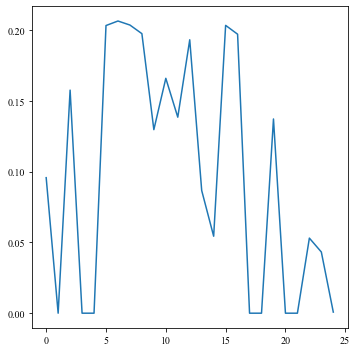

In [369]:
ani = animate({'pc': s[:, list(range(0, s.shape[1], 2))]}, s.shape[0], intvl=1)
HTML(ani.to_jshtml()) # Jupyter

n = 50
m = 2
tau = 10.00
l = 1.00
a = 1.00
lam = 2.00
c0 = 1.50
beta_e = 0.38
beta_i = 0.25
c1 = 1.00


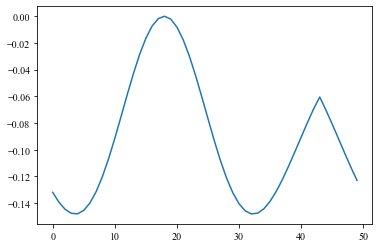

In [363]:
hd = HDir(n=n, m=2, l=1, a=1, lam=2, c0=1.5, tau=10) 
# plt.imshow(hd.W)
# plt.colorbar()
plt.plot(hd.W[10])

In [166]:
# # Get a set of s_init
# n = 40
# T = 3000
# r = 4

# v = np.zeros((T, 2))
# grids = [Hippocampal.Grid2D(n=n, m=4, l=0.25, a=1.0, lam=5, c0=1.1, c1=2, tau=10, 
#                             print_param=False) 
#          for _ in range(r*r)]
# s_init_s = np.zeros((r*r, n*n))
# for i, g in enumerate(grids):
#     s_init_s[i] = g(alpha=0, T=T, v=v, print_param=False)[0][-1]

In [6]:
# fig, ax = plt.subplots(r, r, figsize=(8, 8), sharex='all', sharey='all')
# for i in range(r):
#     for j in range(r):
#         s = s_init_s[i*4+j]
#         ax[i, j].imshow(s.reshape((40, 40)), origin='lower')
        
# fig.tight_layout()

In [7]:
# # Get a set of s_init
# T = 8000
# v = np.zeros((T, 2))
# for i, j in zip(range(8), range(0, 360, 45)):
#     theta = j / 180 * np.pi
#     v[i*1000:(i+1)*1000] = [np.cos(theta), np.sin(theta)]

# s_s = np.zeros((T, 4, r*r, n*n))

# for i, alpha in enumerate((0.2, 0.7, 0.13, 0.18)):
#     for j, g in enumerate(grids):
#         s_s[:, i, j, :] = g(alpha=alpha, T=T, v=v, s_init=s_init_s[0], 
#                             print_param=False)[0]